In [69]:
import warnings
import math
import pandas as pd
import numpy as np
from dbfread import DBF
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    RandomizedSearchCV,
)
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import xgboost as xgb
import shap
from sklearn.inspection import PartialDependenceDisplay

### Load data

In [70]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

df = df.drop(columns=['inidoy', 'enddoy', 'ros_p_lg1'])

df = df[df['ros_p'] > 3000]

for col in df:
    print(col)

Loading dataset...
Dataset loaded
ros_p
duration_p
elev_av
aspect_av
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wdir10_av
wv100_k_av
wdir100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wdi_950_av
wdi_850_av
wdi_700_av
wdi_500_av
wdi_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_s_9_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSdir_9_av
wSv_7_av
wSdir_7_av
wSv_5_av
wSdir_5_av
wSv_1_av
wSdir_1_av
CBH_m_av
HigCC_p_av
LowCC_p_av
MidCC_p_av
TotCC_p_av
Cape_av
Cin_av
BLH_m_av
BLH_m_rt
LCL_hPa_av
LCL_m_av
LFC_hPa_av
CCL_hPa_av
EL_m_av
LiftIdx_av
VentIdx_av
CMLG_av
f_start
geometry


In [71]:
nan_percent = df.isna().mean() * 100

# Imprime a % de NaNs por coluna
for col, perc in nan_percent.items():
    print(f"Coluna '{col}': {perc:.2f}% de NaNs")

df = df.loc[:, nan_percent <= 11]

for col in df:
    print(col)

Coluna 'ros_p': 0.00% de NaNs
Coluna 'duration_p': 0.00% de NaNs
Coluna 'elev_av': 0.00% de NaNs
Coluna 'aspect_av': 0.00% de NaNs
Coluna 'landform': 0.00% de NaNs
Coluna 'land_use': 10.94% de NaNs
Coluna '1_3y_fir_p': 0.00% de NaNs
Coluna '3_8y_fir_p': 0.00% de NaNs
Coluna '8_ny_fir_p': 0.00% de NaNs
Coluna 'fuel_model': 0.00% de NaNs
Coluna 'f_load_av': 0.00% de NaNs
Coluna 'sW_1m_av': 0.00% de NaNs
Coluna 'sW_3m_av': 0.00% de NaNs
Coluna 'sW_7_av': 0.00% de NaNs
Coluna 'sW_28_av': 0.00% de NaNs
Coluna 'sW_100_av': 0.00% de NaNs
Coluna 'sW_289_av': 0.00% de NaNs
Coluna 't_2m_C_av': 0.00% de NaNs
Coluna 'd_2m_C_av': 0.00% de NaNs
Coluna 'rh_2m_av': 0.00% de NaNs
Coluna 'VPD_Pa_av': 0.00% de NaNs
Coluna 'sP_hPa_av': 0.00% de NaNs
Coluna 'gp_m2s2_av': 0.00% de NaNs
Coluna 'dfmc_av': 0.00% de NaNs
Coluna 'HDW_av': 0.00% de NaNs
Coluna 'Haines_av': 0.00% de NaNs
Coluna 'FWI_12h_av': 0.00% de NaNs
Coluna 'DC_12h_av': 0.00% de NaNs
Coluna 'FFMC_12h_a': 0.00% de NaNs
Coluna 'wv10_kh_av': 0.0

### convert categorical variables into "category" type

In [72]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### create log vars

In [73]:
import numpy as np
import pandas as pd

# Seleciona colunas que NÃO são categóricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Cria novas variáveis com log natural
for col in num_cols:
    df[f'{col}_log'] = np.sign(df[col]) * np.log(np.abs(df[col]) + 1)

df = df.drop(columns=['ros_p'])

for col in df.columns:
    print(col)

duration_p
elev_av
aspect_av
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wdir10_av
wv100_k_av
wdir100_av
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wdi_950_av
wdi_850_av
wdi_700_av
wdi_500_av
wdi_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSdir_9_av
wSv_7_av
wSdir_7_av
wSv_5_av
wSdir_5_av
wSv_1_av
wSdir_1_av
HigCC_p_av
LowCC_p_av
MidCC_p_av
TotCC_p_av
Cape_av
BLH_m_av
LCL_hPa_av
LCL_m_av
CCL_hPa_av
LiftIdx_av
VentIdx_av
CMLG_av
f_start
geometry
ros_p_log
duration_p_log
elev_av_log
aspect_av_log
1_3y_fir_p_log
3_8y_fir_p_log
8_ny_fir_p_log
f_load_av_log
sW_1m_av_l

### remove nans from ros_p

In [74]:
n_before = len(df)
df = df.dropna(subset=['ros_p_log']).reset_index(drop=True)
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 0 rows with NaN in 'ros_p'. Remaining rows: 64


### train and test datasets

In [75]:
# Define features (excluding specific columns)

train_features = [col for col in df.columns if col not in ('ros_p_log', 'inidoy', 'enddoy', "geometry")]
# Create initial X and y
X = df[train_features].copy()
y = df['ros_p_log'].copy()


# Remove invalid targets (-1) BEFORE cross-validation 

valid_mask = y != -1
X = X[valid_mask].reset_index(drop=True)
y = y[valid_mask].reset_index(drop=True)

print(f"Total valid samples for Cross-Validation: {len(X)}")

Total valid samples for Cross-Validation: 64


### ALL VARS MODELLING

In [76]:
# ============================================================
# CONFIGURAÇÃO INICIAL
# ============================================================
import numpy as np
import pandas as pd
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*100)
print("🚀 REGRESSÃO LINEAR + REPEATED CV + IMPORTÂNCIA DAS FEATURES")
print("="*100)

# ============================================================
# DADOS
# ============================================================

print(f"📊 X shape: {X.shape}")
print(f"📊 y shape: {y.shape}")
print("   ✔ Target já está log-transformada.")

# ============================================================
# PIPELINE
# ============================================================
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# ============================================================
# REPEATED CROSS VALIDATION
# ============================================================
print("\n🔄 Repeated K-Fold Cross Validation (10 folds × 10 repeats)")
print("="*100)

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

cv_results = []
start = time.time()

for fold, (train_idx, test_idx) in enumerate(rkf.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    cv_results.append([r2, rmse, mae])

elapsed = time.time() - start

cv_results = np.array(cv_results)
mean_r2, std_r2 = cv_results[:,0].mean(), cv_results[:,0].std()
mean_rmse, std_rmse = cv_results[:,1].mean(), cv_results[:,1].std()
mean_mae, std_mae = cv_results[:,2].mean(), cv_results[:,2].std()

print(f"📈 R²:   {mean_r2:.4f} ± {std_r2:.4f}")
print(f"📉 RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"📉 MAE:  {mean_mae:.4f} ± {std_mae:.4f}")
print(f"\n⏱ Tempo total: {elapsed:.1f} segundos")

# ============================================================
# TREINO FINAL NO CONJUNTO COMPLETO
# ============================================================
print("\n🎯 Treinando modelo final com todos os dados")
print("="*100)

final_model = pipeline.fit(X, y)
coef = final_model.named_steps["linreg"].coef_

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": coef,
    "importance": np.abs(coef)
}).sort_values("importance", ascending=False)

print("Top 10 variáveis mais importantes:")
print(coef_df.head(10))


🚀 REGRESSÃO LINEAR + REPEATED CV + IMPORTÂNCIA DAS FEATURES
📊 X shape: (64, 170)
📊 y shape: (64,)
   ✔ Target já está log-transformada.

🔄 Repeated K-Fold Cross Validation (10 folds × 10 repeats)


📈 R²:   -28.8128 ± 102.4932
📉 RMSE: 0.8855 ± 0.7947
📉 MAE:  0.6145 ± 0.3350

⏱ Tempo total: 0.3 segundos

🎯 Treinando modelo final com todos os dados
Top 10 variáveis mais importantes:
            feature      coef  importance
167  VentIdx_av_log  0.609286    0.609286
46        wv_300_av  0.600972    0.600972
131  wdi_850_av_log  0.563751    0.563751
67       wSdir_9_av  0.562133    0.562133
8        fuel_model  0.539727    0.539727
153    wSv_5_av_log -0.467939    0.467939
1           elev_av -0.461457    0.461457
124   rh_300_av_log -0.453682    0.453682
87   duration_p_log  0.432622    0.432622
66         wSv_9_av -0.415498    0.415498


In [109]:
# ============================================================
# Forward Feature Selection com ranking top 20 univariado a cada iteração
# ============================================================

features = list(X.columns)
remaining_features = features.copy()
selected_features = []
results = []

max_iters = 10
iteration = 1

while len(remaining_features) > 0 and iteration <= max_iters:

    best_mae = np.inf
    best_feature = None

    print(f"\n➡ Iteração #{iteration} – {len(selected_features)+1}/{len(features)} features selecionadas")

    # Ranking univariado das features restantes
    univariate_results = []
    for f in remaining_features:
        model = pipeline.fit(X[[f]], y)
        y_pred = model.predict(X[[f]])
        mae_linear = np.mean(np.abs(np.exp(y_pred) - np.exp(y)))
        r2 = r2_score(y, y_pred)
        univariate_results.append([f, r2, mae_linear])
    
    univariate_df = pd.DataFrame(univariate_results, columns=["feature", "R2", "MAE_linear"])
    univariate_df = univariate_df.sort_values("MAE_linear")
    
    print("   🔹 Top 20 features restantes (ranking univariado por MAE):")
    print(univariate_df.head(20).to_string(index=False))

    # Escolher a melhor feature incremental
    for f in remaining_features:
        test_features = selected_features + [f]
        model = pipeline.fit(X[test_features], y)
        y_pred = model.predict(X[test_features])
        mae_linear = np.mean(np.abs(np.exp(y_pred) - np.exp(y)))

        if mae_linear < best_mae:
            best_mae = mae_linear
            best_feature = f

    # Adicionar a feature escolhida
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)

    # Remover versão linear/log oposta
    if best_feature.endswith("_log"):
        alt_var = best_feature.replace("_log", "")
    else:
        alt_var = best_feature + "_log"
    if alt_var in remaining_features:
        remaining_features.remove(alt_var)

    # Métricas finais com features selecionadas
    model = pipeline.fit(X[selected_features], y)
    y_pred = model.predict(X[selected_features])
    r2_final = r2_score(y, y_pred)
    mae_linear_final = np.mean(np.abs(np.exp(y_pred) - np.exp(y)))

    results.append([iteration, best_feature, r2_final, mae_linear_final, best_mae])
    print(f"   ✔ Variável adicionada: {best_feature}")
    print(f"   ⭐ MAE incremental = {best_mae:.4f}, R² = {r2_final:.4f}")

    iteration += 1

# Salvar resultados
ffs_df = pd.DataFrame(results, columns=["iteration", "added_feature", "R2", "MAE_linear", "MAE_selection"])



➡ Iteração #1 – 1/170 features selecionadas
   🔹 Top 20 features restantes (ranking univariado por MAE):
      feature       R2  MAE_linear
     wSv_1_av 0.198067  918.596839
      sW_7_av 0.184094  934.821114
  sW_7_av_log 0.179614  938.086568
 wSv_1_av_log 0.186032  946.085148
gp_500_av_log 0.216474  948.706806
    gp_500_av 0.216358  948.709633
gp_300_av_log 0.207543  953.872912
    gp_300_av 0.207548  953.933081
     t_500_av 0.176396  959.761487
     t_850_av 0.205839  960.145312
 t_850_av_log 0.196695  963.940847
 t_500_av_log 0.172965  965.428316
     t_700_av 0.194221  968.504086
 t_700_av_log 0.189201  969.623797
VPD_Pa_av_log 0.149931  975.979268
    VPD_Pa_av 0.164660  976.455251
     t_300_av 0.166962  978.532016
 LCL_m_av_log 0.104117  981.411912
 t_300_av_log 0.163667  981.648359
   LCL_hPa_av 0.109982  982.239133
   ✔ Variável adicionada: wSv_1_av
   ⭐ MAE incremental = 918.5968, R² = 0.1981

➡ Iteração #2 – 2/170 features selecionadas
   🔹 Top 20 features restantes (ra

In [114]:
# ============================================================
# FORWARD FEATURE SELECTION – top 10 ranking incremental + correlação com rosp
# ============================================================

features = list(X.columns)
remaining_features = features.copy()
selected_features = []
results = []

max_iters = 10
iteration = 1

while len(remaining_features) > 0 and iteration <= max_iters:

    best_mae = np.inf
    best_feature = None

    print(f"\n➡ Iteração #{iteration} – {len(selected_features)+1}/{len(features)} features selecionadas")

    # ============================================================
    # Calcular MAE incremental e correlação com rosp para todas as features restantes
    # ============================================================
    incremental_results = []
    for f in remaining_features:
        test_features = selected_features + [f]
        model = pipeline.fit(X[test_features], y)
        y_pred = model.predict(X[test_features])
        mae_linear = np.mean(np.abs(np.exp(y_pred) - np.exp(y)))
        
        # correlação com rosp
        corr_rosp = X[f].corr(y)
        
        incremental_results.append([f, mae_linear, corr_rosp])

    incremental_df = pd.DataFrame(incremental_results, columns=["feature", "MAE_incremental", "corr_rosp"])
    incremental_df = incremental_df.sort_values("MAE_incremental")

    print("   🔹 Top 10 features restantes (MAE incremental + correlação com rosp):")
    print(incremental_df.head(10).to_string(index=False))

    # ============================================================
    # Escolher a feature que reduz mais o MAE
    # ============================================================
    best_feature = incremental_df.iloc[0]["feature"]
    best_mae = incremental_df.iloc[0]["MAE_incremental"]

    # Adicionar feature ao modelo
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)

    # Remover versão linear/log oposta
    if best_feature.endswith("_log"):
        alt_var = best_feature.replace("_log", "")
    else:
        alt_var = best_feature + "_log"
    if alt_var in remaining_features:
        remaining_features.remove(alt_var)

    # Métricas finais com features selecionadas
    model = pipeline.fit(X[selected_features], y)
    y_pred = model.predict(X[selected_features])
    r2_final = r2_score(y, y_pred)
    mae_linear_final = np.mean(np.abs(np.exp(y_pred) - np.exp(y)))

    results.append([iteration, best_feature, r2_final, mae_linear_final, best_mae])
    print(f"   ✔ Variável adicionada: {best_feature}")
    print(f"   ⭐ MAE incremental = {best_mae:.4f}, R² = {r2_final:.4f}")

    iteration += 1

# ============================================================
# Salvar resultados
# ============================================================
ffs_df = pd.DataFrame(results, columns=["iteration", "added_feature", "R2", "MAE_linear", "MAE_selection"])



➡ Iteração #1 – 1/170 features selecionadas
   🔹 Top 10 features restantes (MAE incremental + correlação com rosp):
      feature  MAE_incremental  corr_rosp
     wSv_1_av       918.596839   0.445048
      sW_7_av       934.821114  -0.429061
  sW_7_av_log       938.086568  -0.423809
 wSv_1_av_log       946.085148   0.431314
gp_500_av_log       948.706806  -0.465267
    gp_500_av       948.709633  -0.465143
gp_300_av_log       953.872912  -0.455568
    gp_300_av       953.933081  -0.455574
     t_500_av       959.761487  -0.419995
     t_850_av       960.145312  -0.453694
   ✔ Variável adicionada: wSv_1_av
   ⭐ MAE incremental = 918.5968, R² = 0.1981

➡ Iteração #2 – 2/170 features selecionadas
   🔹 Top 10 features restantes (MAE incremental + correlação com rosp):
       feature  MAE_incremental  corr_rosp
  BLH_m_av_log       854.548504  -0.358765
wv10_kh_av_log       856.813620  -0.028863
    HDW_av_log       860.239763  -0.267311
    wv100_k_av       862.258348   0.218918
    wv10_

In [93]:
# ============================================================
# SHAP + PREDIÇÕES CV + MERGE COM SHAPEFILE (modelo final)
# ============================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import shap
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm

# ------------------------------------------------------------
# 1. Variáveis e target do modelo final
# ------------------------------------------------------------
X_shap = X_final.copy()
y_shap = y_final.copy()
final_features = X_shap.columns.tolist()

# ------------------------------------------------------------
# 2. Configurações de CV
# ------------------------------------------------------------
n_splits = 10
n_repeats = 5
random_state = 42
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# DataFrames para armazenar resultados
shap_results = pd.DataFrame(index=X_shap.index, columns=[
    'ros_p_log','ros_p_linear','PredROS_log','PredROS_linear',
    'PredDiff','Err_pct','Error_p_abs'
])
shap_values_all = pd.DataFrame(index=X_shap.index, columns=final_features)

# ------------------------------------------------------------
# 3. Repeated CV para previsões
# ------------------------------------------------------------
print("🔄 Calculando PredROS com Repeated CV...")

for train_idx, test_idx in tqdm(rkf.split(X_shap), total=n_splits*n_repeats):
    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    model_cv = pipeline.fit(X_train, y_train)
    y_pred_test = model_cv.predict(X_test)

    # armazenar previsões log
    shap_results.loc[X_test.index, 'PredROS_log'] = y_pred_test
    shap_results.loc[X_test.index, 'ros_p_log'] = y_test

# ------------------------------------------------------------
# 4. Converter para escala linear (safe log)
# ------------------------------------------------------------
def safe_log_inverse(x_log):
    return np.sign(x_log) * (np.exp(np.abs(x_log)) - 1)

shap_results['PredROS_linear'] = safe_log_inverse(pd.to_numeric(shap_results['PredROS_log'], errors='coerce').fillna(0))
shap_results['ros_p_linear'] = safe_log_inverse(pd.to_numeric(shap_results['ros_p_log'], errors='coerce').fillna(0))

# métricas derivadas
mean_predros = shap_results['PredROS_linear'].mean()
shap_results['PredDiff'] = shap_results['PredROS_linear'] - mean_predros
shap_results['Err_pct'] = ((shap_results['PredROS_linear'] - shap_results['ros_p_linear']) / shap_results['ros_p_linear']) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()

# marcar previsões ruins
threshold = 35  # 35%
shap_results['bad_pred'] = shap_results['Error_p_abs'] > threshold

# ------------------------------------------------------------
# 5. Calcular SHAP values
# ------------------------------------------------------------
print("🔹 Calculando SHAP values para todas as features do modelo final...")
explainer = shap.LinearExplainer(final_model.named_steps["linreg"], X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_shap)
shap_values_df = pd.DataFrame(shap_values, columns=final_features, index=X_shap.index)

# ------------------------------------------------------------
# 6. Merge com GeoDataFrame original
# ------------------------------------------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)

# Reset index para concatenar corretamente
shap_results_reset = shap_results.reset_index(drop=True)
shap_values_reset = shap_values_df.reset_index(drop=True)

# Prefixar colunas para evitar duplicatas
shap_values_reset = shap_values_reset.add_prefix('shap_')

# Concatenar: gdf + shap_results + shap_values
merged_gdf_gpd = pd.concat([gdf, shap_results_reset, shap_values_reset], axis=1)
merged_gdf_gpd = gpd.GeoDataFrame(merged_gdf_gpd, geometry='geometry', crs=gdf.crs)

# ------------------------------------------------------------
# 7. Salvar shapefile e CSV
# ------------------------------------------------------------
out_shapefile = r"..\..\Data\Models\PT_FireProg_model_SHAP_Linear.shp"
merged_gdf_gpd.to_file(out_shapefile)
print(f"\n✅ SHAP + PredROS + geometria + features salvo em shapefile: {out_shapefile}")

out_csv = r"..\..\Data\Models\PT_FireProg_model_SHAP_Linear.csv"
merged_gdf_gpd.drop(columns='geometry').to_csv(out_csv, index=False)
print(f"\n✅ SHAP + PredROS + features salvo também em CSV: {out_csv}")


🔄 Calculando PredROS com Repeated CV...


100%|██████████| 50/50 [00:00<00:00, 195.31it/s]


🔹 Calculando SHAP values para todas as features do modelo final...

✅ SHAP + PredROS + geometria + features salvo em shapefile: ..\..\Data\Models\PT_FireProg_model_SHAP_Linear.shp

✅ SHAP + PredROS + features salvo também em CSV: ..\..\Data\Models\PT_FireProg_model_SHAP_Linear.csv


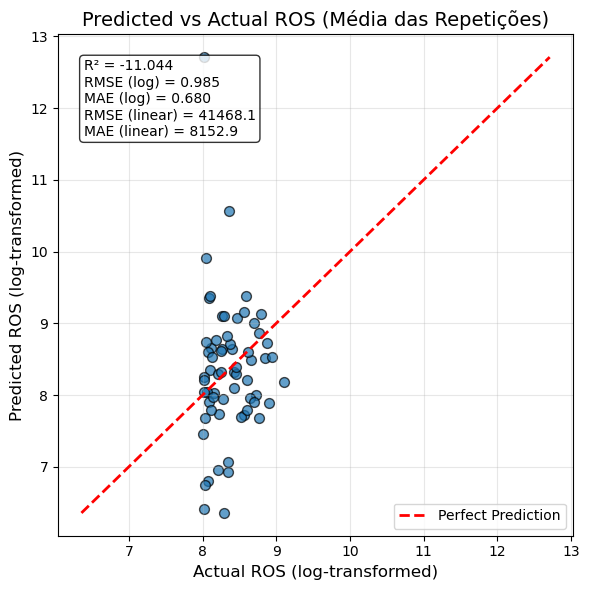

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ============================================================
# 1. Acumular previsões de cada fold para cada observação
# ============================================================
pred_matrix = np.full((len(y), rkf.get_n_splits()), np.nan)

for fold_idx, (train_idx, test_idx) in enumerate(rkf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_pred = pipeline.fit(X_train, y_train).predict(X_test)
    pred_matrix[test_idx, fold_idx] = y_pred

# Média das previsões
avg_pred_log = np.nanmean(pred_matrix, axis=1)
avg_actual_log = y.values

# ============================================================
# 2. Função para reverter log
# ============================================================
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

# ============================================================
# 3. Métricas
# ============================================================
r2_avg = r2_score(avg_actual_log, avg_pred_log)
mae_log_avg = mean_absolute_error(avg_actual_log, avg_pred_log)
rmse_log_avg = np.sqrt(mean_squared_error(avg_actual_log, avg_pred_log))

y_actual_linear = inverse_safe_log(avg_actual_log)
y_pred_linear = inverse_safe_log(avg_pred_log)
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))

# ============================================================
# 4. Scatter plot Predicted vs Actual
# ============================================================
plt.figure(figsize=(6, 6))
plt.scatter(avg_actual_log, avg_pred_log, alpha=0.7, edgecolor='k', s=50)

min_val = min(avg_actual_log.min(), avg_pred_log.min())
max_val = max(avg_actual_log.max(), avg_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual ROS (Média das Repetições)', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(
    0.05, 0.95,
    f'R² = {r2_avg:.3f}\n'
    f'RMSE (log) = {rmse_log_avg:.3f}\n'
    f'MAE (log) = {mae_log_avg:.3f}\n'
    f'RMSE (linear) = {rmse_linear_avg:.1f}\n'
    f'MAE (linear) = {mae_linear_avg:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


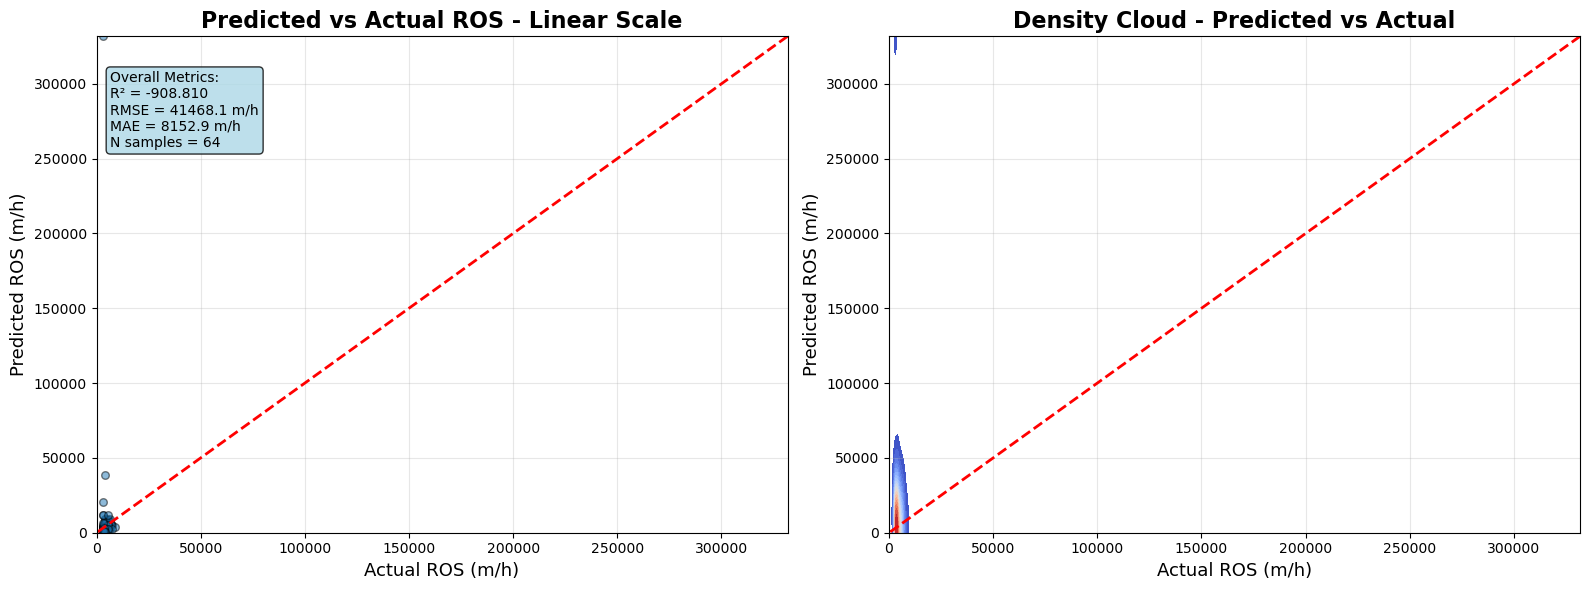

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================================
# 1. Converter de log → linear
# ============================================================
y_actual_linear = inverse_safe_log(avg_actual_log)
y_pred_linear = inverse_safe_log(avg_pred_log)

# ============================================================
# 2. Métricas lineares
# ============================================================
r2_linear = r2_score(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)

# ============================================================
# 3. Scatter + 2D KDE plot
# ============================================================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]}
)

# Limites uniformes para ambos os gráficos
min_val = min(y_actual_linear.min(), y_pred_linear.min())
max_val = max(y_actual_linear.max(), y_pred_linear.max())

# -------------------------
# Left panel: Scatter plot
# -------------------------
ax1.scatter(y_actual_linear, y_pred_linear, alpha=0.5, edgecolor='k', s=30)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_title('Predicted vs Actual ROS - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

metrics_text = (
    f'Overall Metrics:\n'
    f'R² = {r2_linear:.3f}\n'
    f'RMSE = {rmse_linear_avg:.1f} m/h\n'
    f'MAE = {mae_linear_avg:.1f} m/h\n'
    f'N samples = {len(y_actual_linear)}'
)
ax1.text(
    0.02, 0.93, metrics_text,
    transform=ax1.transAxes, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    fontsize=10
)

ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.grid(True, alpha=0.3)

# -------------------------
# Right panel: 2D KDE density plot
# -------------------------
sns.kdeplot(
    x=y_actual_linear, y=y_pred_linear,
    ax=ax2, fill=True, cmap="coolwarm",
    levels=20, thresh=0.04
)

ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


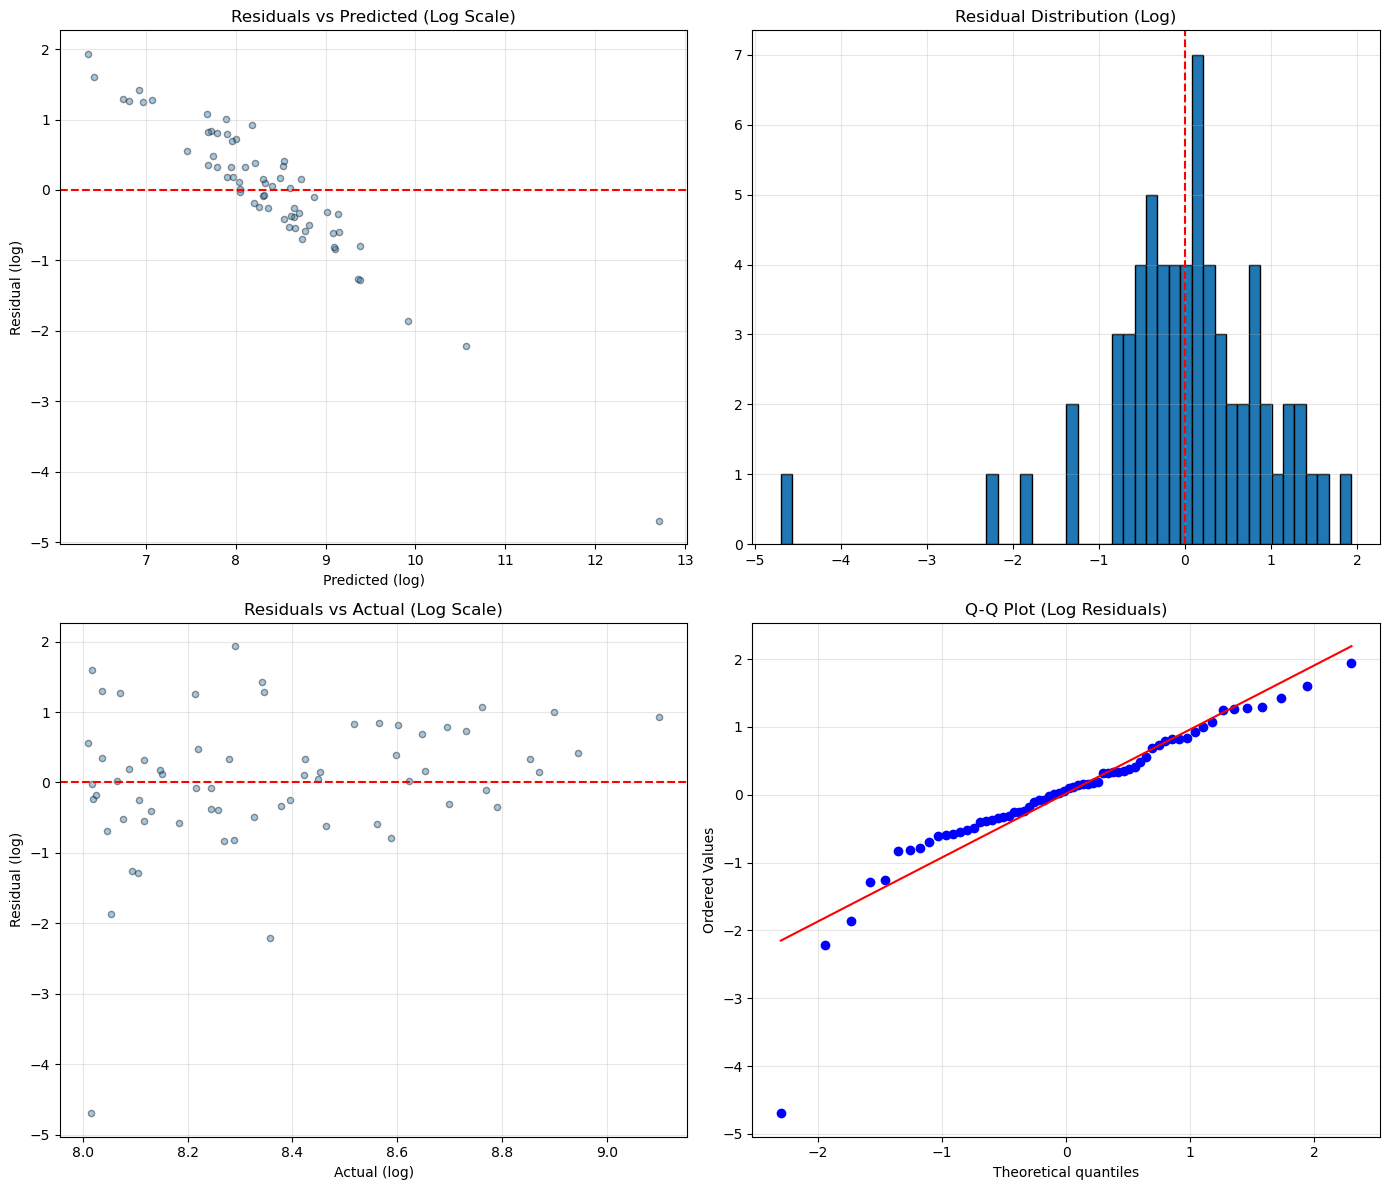

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# ============================================================
# 1. Usar médias do Repeated K-Fold
# ============================================================
avg_actual = avg_actual_log   # valores reais médios (log)
avg_pred   = avg_pred_log     # valores previstos médios (log)

# Conversão para escala linear, se quiser usar depois
avg_actual_linear = inverse_safe_log(avg_actual)
avg_pred_linear   = inverse_safe_log(avg_pred)

# Resíduos na escala log
residuals_log = avg_actual - avg_pred

# ============================================================
# 2. Plots de diagnóstico dos resíduos
# ============================================================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# -------------------------
# Residuals vs Predicted
# -------------------------
ax[0,0].scatter(avg_pred, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Log Scale)")
ax[0,0].set_xlabel("Predicted (log)")
ax[0,0].set_ylabel("Residual (log)")
ax[0,0].grid(True, alpha=0.3)

# -------------------------
# Histogram of residuals
# -------------------------
ax[0,1].hist(residuals_log, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Log)")
ax[0,1].grid(True, alpha=0.3)

# -------------------------
# Residuals vs Actual
# -------------------------
ax[1,0].scatter(avg_actual, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Log Scale)")
ax[1,0].set_xlabel("Actual (log)")
ax[1,0].set_ylabel("Residual (log)")
ax[1,0].grid(True, alpha=0.3)

# -------------------------
# Q-Q Plot
# -------------------------
stats.probplot(residuals_log, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Log Residuals)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


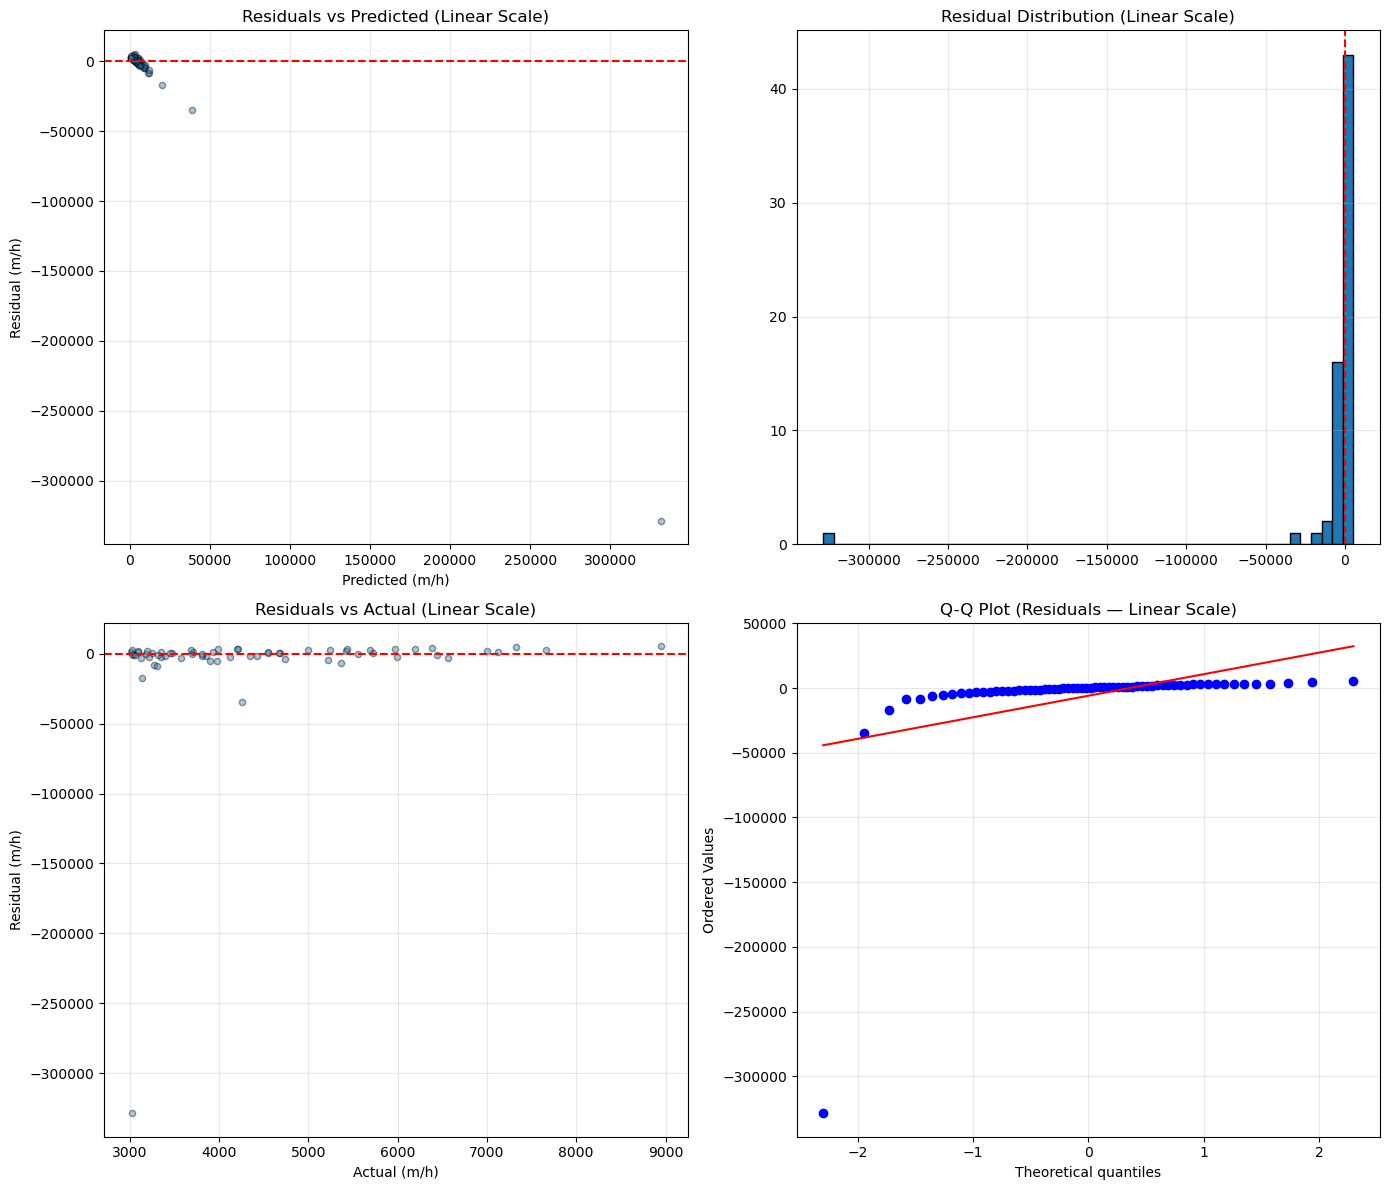

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Valores médios em escala log
# =============================
avg_actual_log = avg_actual_log      # já calculado antes
avg_pred_log   = avg_pred_log        # já calculado antes

# =============================
# Converter para escala linear
# =============================
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Resíduos em escala linear
# =============================
residuals_linear = avg_actual_linear - avg_pred_linear

# =============================
# RESIDUAL PLOTS — LINEAR SCALE
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Linear Scale)")
ax[0,0].set_xlabel("Predicted (m/h)")
ax[0,0].set_ylabel("Residual (m/h)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram
ax[0,1].hist(residuals_linear, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Linear Scale)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Linear Scale)")
ax[1,0].set_xlabel("Actual (m/h)")
ax[1,0].set_ylabel("Residual (m/h)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q plot
stats.probplot(residuals_linear, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Residuals — Linear Scale)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction Quality Summary (Threshold = ±35.0%):
---------------------------------------------------------
Good Predictions : 25  (39.1%)
Bad Predictions  : 39  (60.9%)


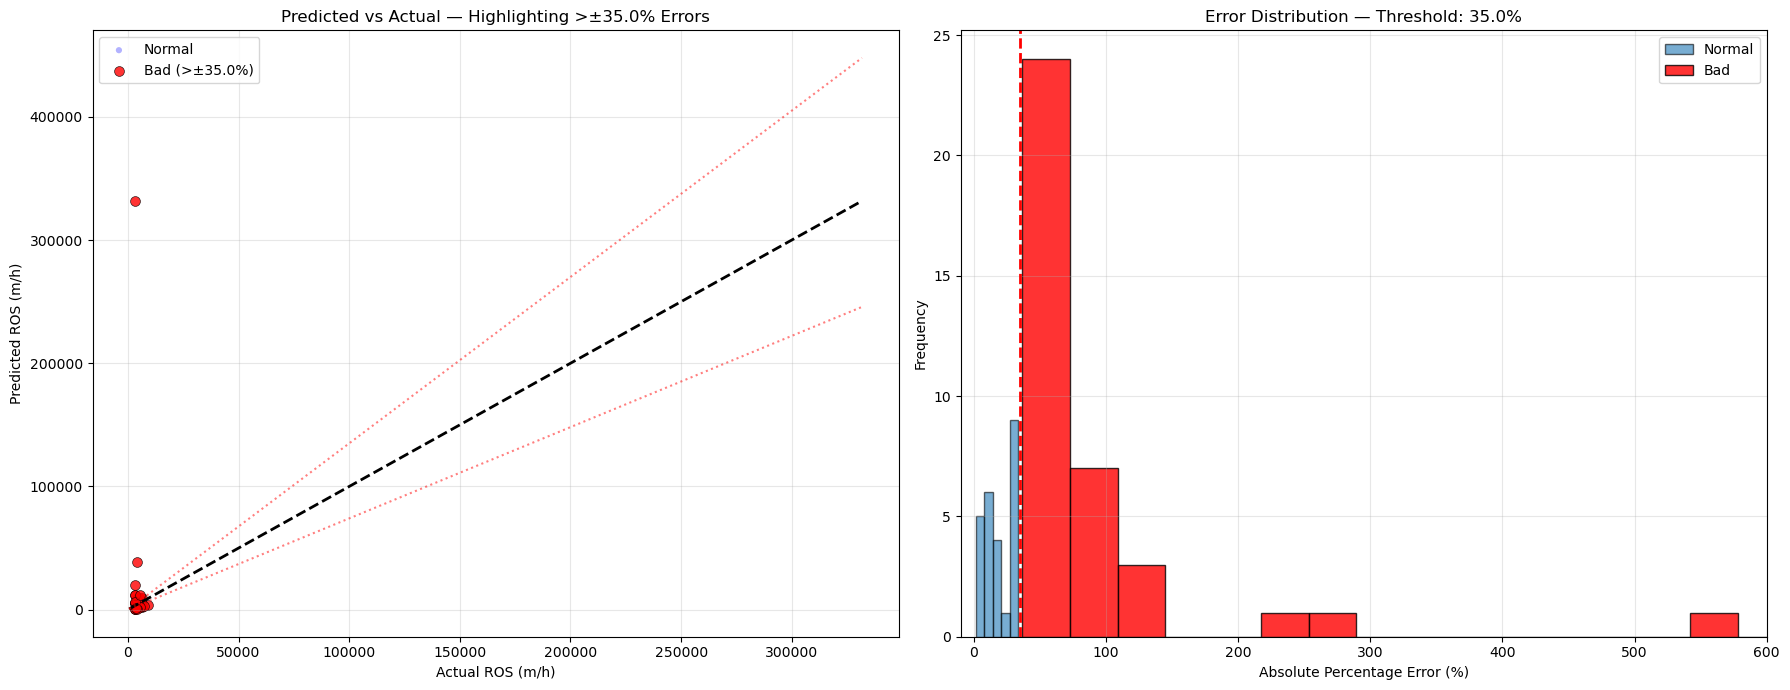

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Configurações
# =============================
threshold = 35.0

# Residuals lineares
residuals = avg_pred_linear - avg_actual_linear

# Percentual de erro
with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(
        avg_actual_linear != 0,
        (residuals / avg_actual_linear) * 100,
        0
    )
percent_errors = np.abs(percent_errors_signed)

# Máscara de "bad predictions"
bad_pred_mask = percent_errors > threshold

# =============================
# Estatísticas
# =============================
n_total = len(bad_pred_mask)
n_bad   = bad_pred_mask.sum()
n_good  = n_total - n_bad

pct_bad  = (n_bad / n_total) * 100
pct_good = (n_good / n_total) * 100

print(f"\nPrediction Quality Summary (Threshold = ±{threshold}%):")
print("---------------------------------------------------------")
print(f"Good Predictions : {n_good}  ({pct_good:.1f}%)")
print(f"Bad Predictions  : {n_bad}  ({pct_bad:.1f}%)")

# =============================
# PLOT 1 — SCATTER ACTUAL vs PREDICTED
# =============================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Normal predictions
ax[0].scatter(
    avg_actual_linear[~bad_pred_mask],
    avg_pred_linear[~bad_pred_mask],
    alpha=0.3, s=20, c='blue', edgecolor='none', label='Normal'
)

# Bad predictions
ax[0].scatter(
    avg_actual_linear[bad_pred_mask],
    avg_pred_linear[bad_pred_mask],
    alpha=0.8, s=50, c='red', edgecolor='black', linewidth=0.5,
    label=f'Bad (>±{threshold}%)'
)

# Linha de previsão perfeita
min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# Faixas do threshold
x_range = np.linspace(min_val, max_val, 100)
factor = 1 + threshold/100
ax[0].plot(x_range, x_range * factor, 'r:', linewidth=1.5, alpha=0.5)
ax[0].plot(x_range, x_range / factor, 'r:', linewidth=1.5, alpha=0.5)

ax[0].set_xlabel("Actual ROS (m/h)")
ax[0].set_ylabel("Predicted ROS (m/h)")
ax[0].set_title(f"Predicted vs Actual — Highlighting >±{threshold}% Errors")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# =============================
# PLOT 2 — HISTOGRAM ERROR DISTRIBUTION
# =============================
ax[1].hist(percent_errors[~bad_pred_mask], bins=5, alpha=0.6, edgecolor='black', label='Normal')
ax[1].hist(percent_errors[bad_pred_mask], bins=300, alpha=0.8, color='red', edgecolor='black', label='Bad')

ax[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2)

ax[1].set_xlabel("Absolute Percentage Error (%)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-10, 600)
ax[1].set_title(f"Error Distribution — Threshold: {threshold}%")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()


# benchmark 

Intercept (ln(a)): 8.360575091011173
Coeficientes:
  wv10_kh_av_log: 0.0090
  dfmc_av: 0.0964
  FFMC_12h_a: 0.0102

R² = 0.0983
MAE = 0.2183


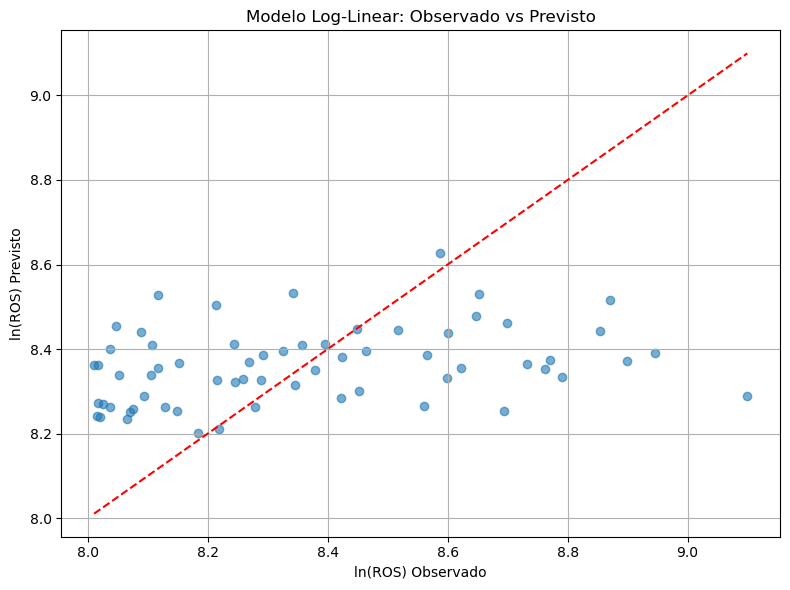


✅ Modelo salvo em 'model_benchmark.pkl'


In [99]:
# ============================================================
# MODELO LOG-LINEAR ROS ~ wv10_log + dfmc + LFMC
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# ------------------------------------------------------------
# 1. Selecionar variáveis
# ------------------------------------------------------------
X_model = X[["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]]  # ajuste se nomes diferentes
y_model = y  # ln(ROS), já log-transformado

# ------------------------------------------------------------
# 2. Criar pipeline
# ------------------------------------------------------------
pipeline_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# ------------------------------------------------------------
# 3. Treinar modelo
# ------------------------------------------------------------
pipeline_model.fit(X_model, y_model)

# ------------------------------------------------------------
# 4. Coeficientes e intercepto
# ------------------------------------------------------------
coef = pipeline_model.named_steps["linreg"].coef_
intercept = pipeline_model.named_steps["linreg"].intercept_

print("Intercept (ln(a)):", intercept)
print("Coeficientes:")
for var, c in zip(X_model.columns, coef):
    print(f"  {var}: {c:.4f}")

# ------------------------------------------------------------
# 5. Avaliar métricas
# ------------------------------------------------------------
y_pred = pipeline_model.predict(X_model)
r2 = r2_score(y_model, y_pred)
mae = mean_absolute_error(y_model, y_pred)
print(f"\nR² = {r2:.4f}")
print(f"MAE = {mae:.4f}")

# ------------------------------------------------------------
# 6. Plot ROS observado vs previsto
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_model, y_pred, alpha=0.6)
plt.plot([y_model.min(), y_model.max()], [y_model.min(), y_model.max()], "r--")
plt.xlabel("ln(ROS) Observado")
plt.ylabel("ln(ROS) Previsto")
plt.title("Modelo Log-Linear: Observado vs Previsto")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7. Salvar modelo em arquivo .pkl
# ------------------------------------------------------------
with open(r"..\..\Data\Models\model_benchmark.pkl", "wb") as f:
    pickle.dump(pipeline_model, f)

print("\n✅ Modelo salvo em 'model_benchmark.pkl'")

In [100]:
# ============================================================
# SHAP + PREDIÇÕES CV + MERGE COM SHAPEFILE (log-linear ROS)
# ============================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# ------------------------------------------------------------
# 1. Selecionar variáveis e target
# ------------------------------------------------------------
X_shap = X[["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]].copy()
y_shap = y.copy()  # ln(ROS)

final_features = X_shap.columns.tolist()

# ------------------------------------------------------------
# 2. Configurações de CV
# ------------------------------------------------------------
n_splits = 10
n_repeats = 5
random_state = 42
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# Pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# DataFrames para armazenar resultados
shap_results = pd.DataFrame(index=X_shap.index, columns=[
    'ros_p_log','ros_p_linear','PredROS_log','PredROS_linear',
    'PredDiff','Err_pct','Error_p_abs'
])
shap_values_all = pd.DataFrame(index=X_shap.index, columns=final_features)

# ------------------------------------------------------------
# 3. Repeated CV para previsões
# ------------------------------------------------------------
print("🔄 Calculando PredROS com Repeated CV...")

for train_idx, test_idx in tqdm(rkf.split(X_shap), total=n_splits*n_repeats):
    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    model_cv = pipeline.fit(X_train, y_train)
    y_pred_test = model_cv.predict(X_test)

    # armazenar previsões log
    shap_results.loc[X_test.index, 'PredROS_log'] = y_pred_test
    shap_results.loc[X_test.index, 'ros_p_log'] = y_test

# ------------------------------------------------------------
# 4. Converter para escala linear (safe log)
# ------------------------------------------------------------
def safe_log_inverse(x_log):
    return np.sign(x_log) * (np.exp(np.abs(x_log)) - 1)

shap_results['PredROS_linear'] = safe_log_inverse(pd.to_numeric(shap_results['PredROS_log'], errors='coerce').fillna(0))
shap_results['ros_p_linear'] = safe_log_inverse(pd.to_numeric(shap_results['ros_p_log'], errors='coerce').fillna(0))

# métricas derivadas
mean_predros = shap_results['PredROS_linear'].mean()
shap_results['PredDiff'] = shap_results['PredROS_linear'] - mean_predros
shap_results['Err_pct'] = ((shap_results['PredROS_linear'] - shap_results['ros_p_linear']) / shap_results['ros_p_linear']) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()

# =============================
# 3.1 — Marcar previsões ruins
# =============================
threshold = 35  # 35%
shap_results['bad_pred'] = shap_results['Error_p_abs'] > threshold

# ------------------------------------------------------------
# 5. Calcular SHAP values
# ------------------------------------------------------------
print("🔹 Calculando SHAP values para todas as features...")
explainer = shap.LinearExplainer(pipeline.named_steps["linreg"], X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_shap)
shap_values_df = pd.DataFrame(shap_values, columns=final_features, index=X_shap.index)

# ------------------------------------------------------------
# 6. Merge vetorizado com gdf preservando geometria
# ------------------------------------------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)  # GeoDataFrame original

# Reset index para concatenar corretamente
shap_results_reset = shap_results.reset_index(drop=True)
shap_values_reset = shap_values_df.reset_index(drop=True)

# Prefixar colunas para evitar duplicatas
shap_values_reset = shap_values_reset.add_prefix('shap_')

# Concatenar: gdf + shap_results + shap_values
merged_gdf_gpd = pd.concat([gdf, shap_results_reset, shap_values_reset], axis=1)
merged_gdf_gpd = gpd.GeoDataFrame(merged_gdf_gpd, geometry='geometry', crs=gdf.crs)

# ------------------------------------------------------------
# 7. Salvar shapefile e CSV
# ------------------------------------------------------------
out_shapefile = r"..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.shp"
merged_gdf_gpd.to_file(out_shapefile)
print(f"\n✅ SHAP + PredROS + geometria + features salvo em shapefile: {out_shapefile}")

out_csv = r"..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.csv"
merged_gdf_gpd.drop(columns='geometry').to_csv(out_csv, index=False)
print(f"\n✅ SHAP + PredROS + features salvo também em CSV: {out_csv}")


🔄 Calculando PredROS com Repeated CV...


100%|██████████| 50/50 [00:00<00:00, 220.27it/s]


🔹 Calculando SHAP values para todas as features...

✅ SHAP + PredROS + geometria + features salvo em shapefile: ..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.shp

✅ SHAP + PredROS + features salvo também em CSV: ..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.csv


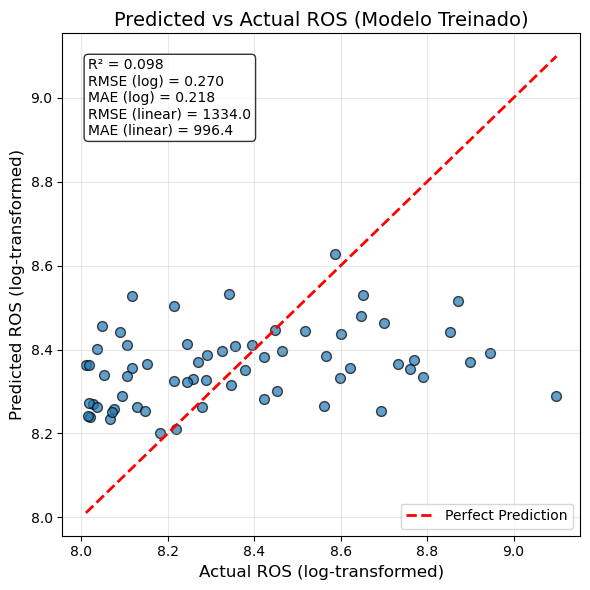

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ============================================================
# 1. Previsão usando o modelo treinado no primeiro script
# ============================================================
y_pred_log = pipeline_model.predict(X_model)  # X_model é o mesmo usado no treino
y_actual_log = y_model.values

# ============================================================
# 2. Função para reverter log
# ============================================================
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

# ============================================================
# 3. Métricas
# ============================================================
r2_log = r2_score(y_actual_log, y_pred_log)
mae_log = mean_absolute_error(y_actual_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_actual_log, y_pred_log))

y_actual_linear = inverse_safe_log(y_actual_log)
y_pred_linear = inverse_safe_log(y_pred_log)
mae_linear = mean_absolute_error(y_actual_linear, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))

# ============================================================
# 4. Scatter plot Predicted vs Actual
# ============================================================
plt.figure(figsize=(6, 6))
plt.scatter(y_actual_log, y_pred_log, alpha=0.7, edgecolor='k', s=50)

min_val = min(y_actual_log.min(), y_pred_log.min())
max_val = max(y_actual_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual ROS (Modelo Treinado)', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(
    0.05, 0.95,
    f'R² = {r2_log:.3f}\n'
    f'RMSE (log) = {rmse_log:.3f}\n'
    f'MAE (log) = {mae_log:.3f}\n'
    f'RMSE (linear) = {rmse_linear:.1f}\n'
    f'MAE (linear) = {mae_linear:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


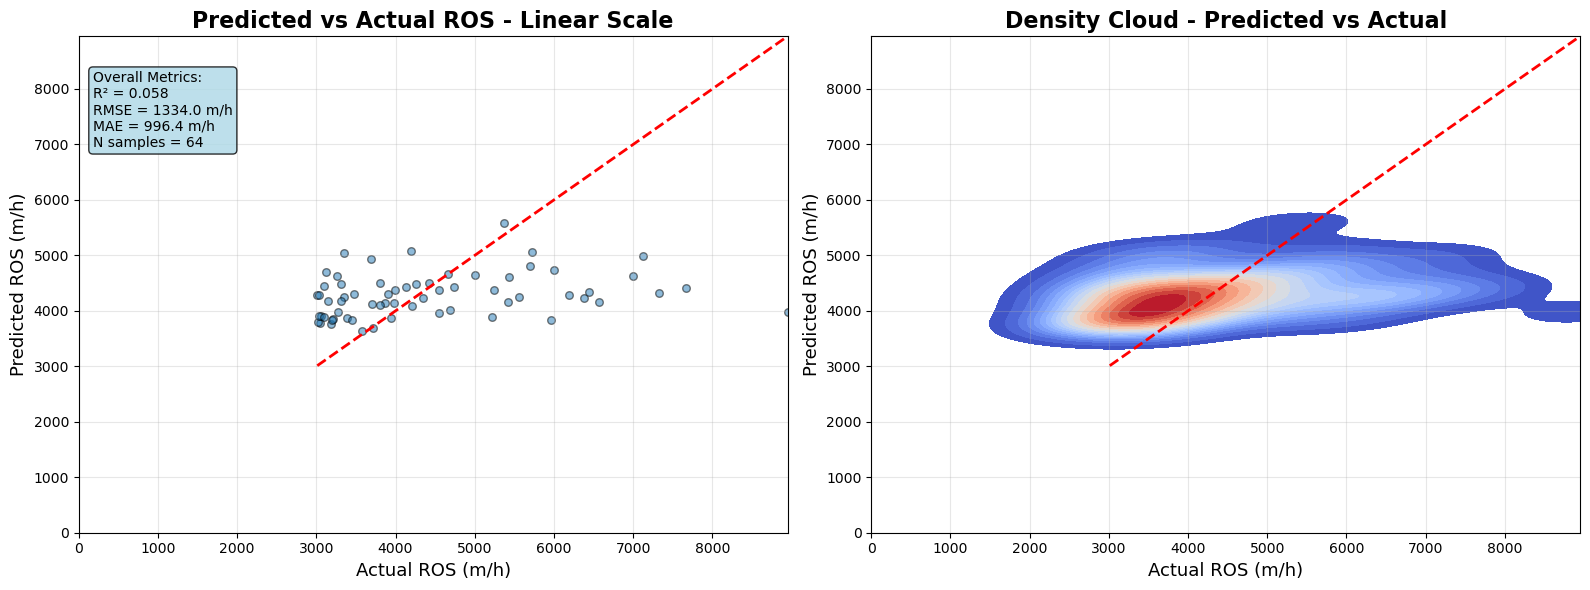

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================================
# 1. Converter de log → linear
# ============================================================
y_actual_linear = inverse_safe_log(y_model.values)
y_pred_linear = inverse_safe_log(pipeline_model.predict(X_model))

# ============================================================
# 2. Métricas lineares
# ============================================================
r2_linear = r2_score(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)

# ============================================================
# 3. Scatter + 2D KDE plot
# ============================================================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]}
)

# Limites uniformes para ambos os gráficos
min_val = min(y_actual_linear.min(), y_pred_linear.min())
max_val = max(y_actual_linear.max(), y_pred_linear.max())

# -------------------------
# Left panel: Scatter plot
# -------------------------
ax1.scatter(y_actual_linear, y_pred_linear, alpha=0.5, edgecolor='k', s=30)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_title('Predicted vs Actual ROS - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

metrics_text = (
    f'Overall Metrics:\n'
    f'R² = {r2_linear:.3f}\n'
    f'RMSE = {rmse_linear_avg:.1f} m/h\n'
    f'MAE = {mae_linear_avg:.1f} m/h\n'
    f'N samples = {len(y_actual_linear)}'
)
ax1.text(
    0.02, 0.93, metrics_text,
    transform=ax1.transAxes, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    fontsize=10
)

ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.grid(True, alpha=0.3)

# -------------------------
# Right panel: 2D KDE density plot
# -------------------------
sns.kdeplot(
    x=y_actual_linear, y=y_pred_linear,
    ax=ax2, fill=True, cmap="coolwarm",
    levels=20, thresh=0.04
)

ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


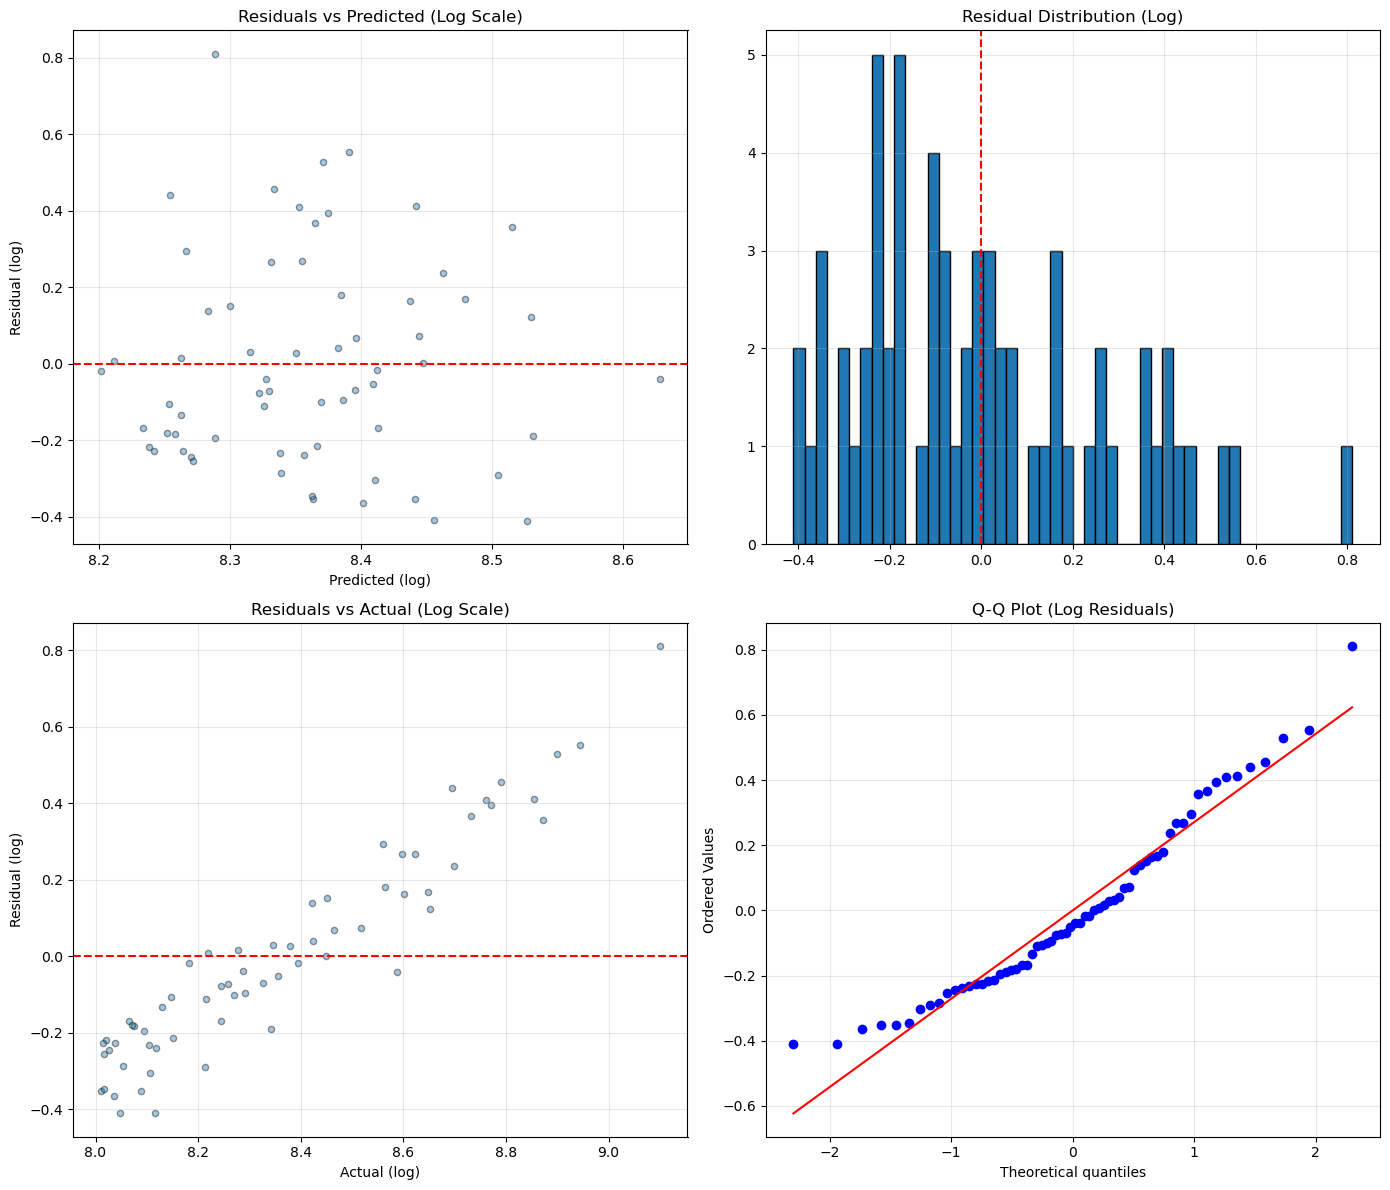

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# ============================================================
# 1. Usar médias do Repeated K-Fold
# ============================================================
avg_actual = y_model.values
avg_pred   = pipeline_model.predict(X_model)

# Conversão para escala linear, se quiser usar depois
avg_actual_linear = inverse_safe_log(avg_actual)
avg_pred_linear   = inverse_safe_log(avg_pred)

# Resíduos na escala log
residuals_log = avg_actual - avg_pred

# ============================================================
# 2. Plots de diagnóstico dos resíduos
# ============================================================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# -------------------------
# Residuals vs Predicted
# -------------------------
ax[0,0].scatter(avg_pred, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Log Scale)")
ax[0,0].set_xlabel("Predicted (log)")
ax[0,0].set_ylabel("Residual (log)")
ax[0,0].grid(True, alpha=0.3)

# -------------------------
# Histogram of residuals
# -------------------------
ax[0,1].hist(residuals_log, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Log)")
ax[0,1].grid(True, alpha=0.3)

# -------------------------
# Residuals vs Actual
# -------------------------
ax[1,0].scatter(avg_actual, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Log Scale)")
ax[1,0].set_xlabel("Actual (log)")
ax[1,0].set_ylabel("Residual (log)")
ax[1,0].grid(True, alpha=0.3)

# -------------------------
# Q-Q Plot
# -------------------------
stats.probplot(residuals_log, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Log Residuals)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


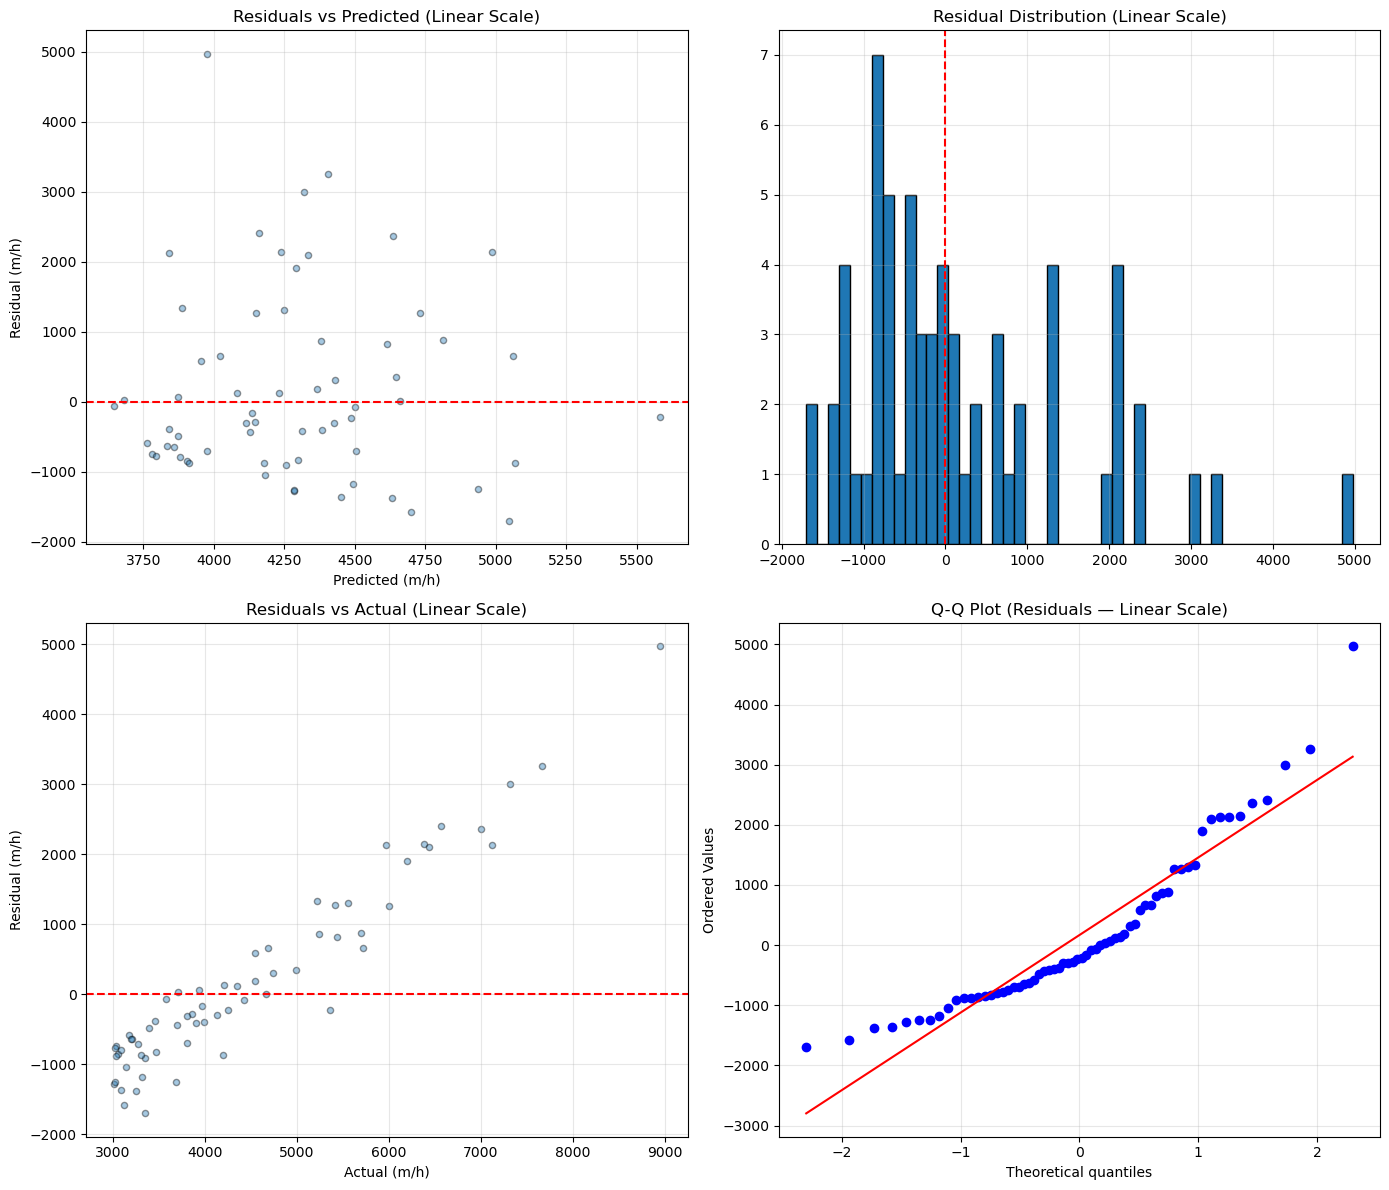

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Valores médios em escala log
# =============================
avg_actual_log = y_model.values
avg_pred_log   = pipeline_model.predict(X_model)

# =============================
# Converter para escala linear
# =============================
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Resíduos em escala linear
# =============================
residuals_linear = avg_actual_linear - avg_pred_linear

# =============================
# RESIDUAL PLOTS — LINEAR SCALE
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Linear Scale)")
ax[0,0].set_xlabel("Predicted (m/h)")
ax[0,0].set_ylabel("Residual (m/h)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram
ax[0,1].hist(residuals_linear, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Linear Scale)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Linear Scale)")
ax[1,0].set_xlabel("Actual (m/h)")
ax[1,0].set_ylabel("Residual (m/h)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q plot
stats.probplot(residuals_linear, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Residuals — Linear Scale)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction Quality Summary (Threshold = ±35.0%):
---------------------------------------------------------
Good Predictions : 52  (81.2%)
Bad Predictions  : 12  (18.8%)


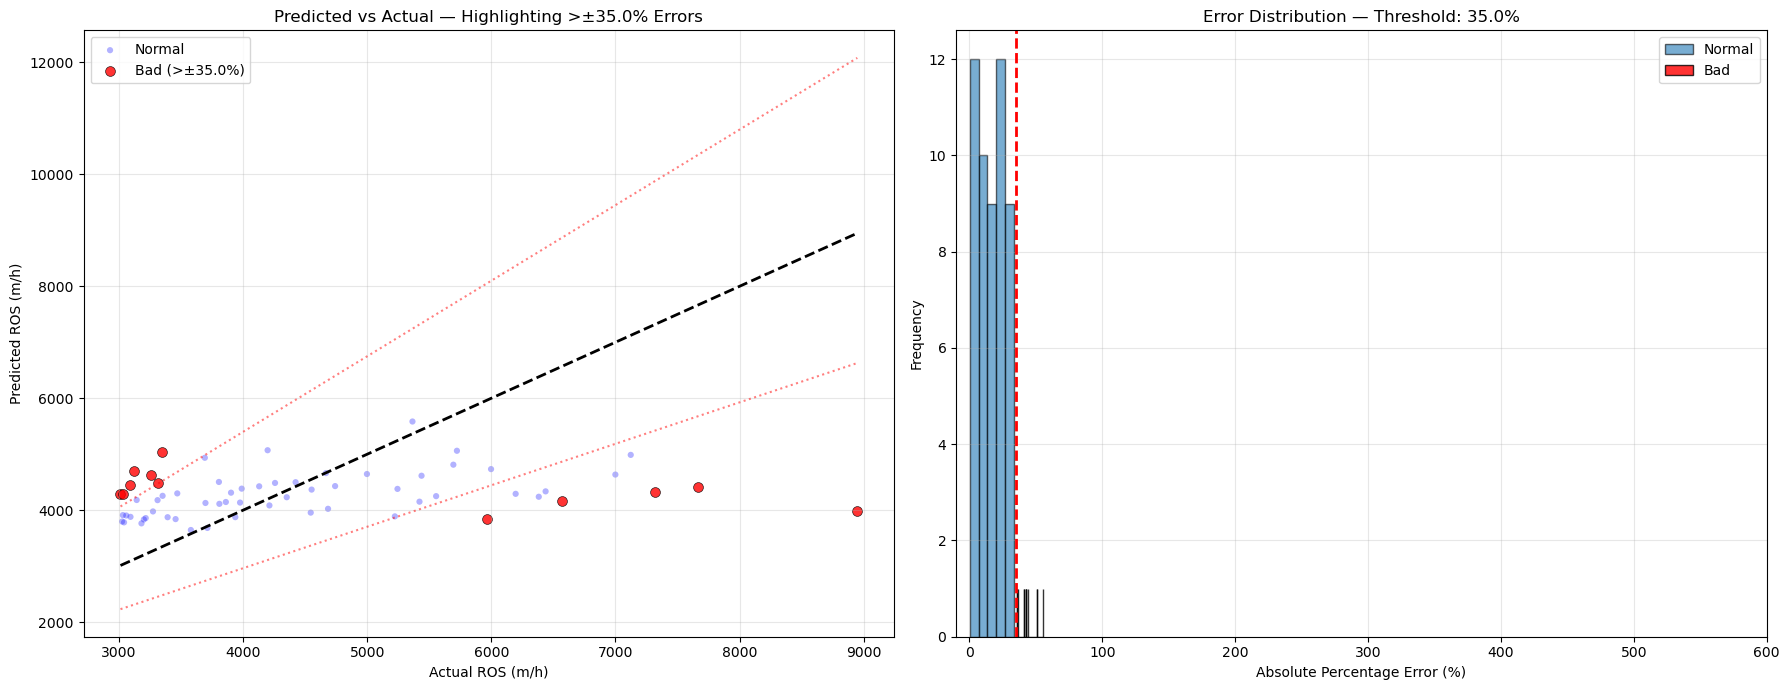

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Usar previsões do modelo final
# =============================
avg_actual_log = y_model.values
avg_pred_log   = pipeline_model.predict(X_model)

# Converter para escala linear
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Configurações
# =============================
threshold = 35.0

# Residuals lineares
residuals = avg_pred_linear - avg_actual_linear

# Percentual de erro
with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(
        avg_actual_linear != 0,
        (residuals / avg_actual_linear) * 100,
        0
    )
percent_errors = np.abs(percent_errors_signed)

# Máscara de "bad predictions"
bad_pred_mask = percent_errors > threshold

# =============================
# Estatísticas
# =============================
n_total = len(bad_pred_mask)
n_bad   = bad_pred_mask.sum()
n_good  = n_total - n_bad

pct_bad  = (n_bad / n_total) * 100
pct_good = (n_good / n_total) * 100

print(f"\nPrediction Quality Summary (Threshold = ±{threshold}%):")
print("---------------------------------------------------------")
print(f"Good Predictions : {n_good}  ({pct_good:.1f}%)")
print(f"Bad Predictions  : {n_bad}  ({pct_bad:.1f}%)")

# =============================
# PLOT 1 — SCATTER ACTUAL vs PREDICTED
# =============================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Normal predictions
ax[0].scatter(
    avg_actual_linear[~bad_pred_mask],
    avg_pred_linear[~bad_pred_mask],
    alpha=0.3, s=20, c='blue', edgecolor='none', label='Normal'
)

# Bad predictions
ax[0].scatter(
    avg_actual_linear[bad_pred_mask],
    avg_pred_linear[bad_pred_mask],
    alpha=0.8, s=50, c='red', edgecolor='black', linewidth=0.5,
    label=f'Bad (>±{threshold}%)'
)

# Linha de previsão perfeita
min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# Faixas do threshold
x_range = np.linspace(min_val, max_val, 100)
factor = 1 + threshold/100
ax[0].plot(x_range, x_range * factor, 'r:', linewidth=1.5, alpha=0.5)
ax[0].plot(x_range, x_range / factor, 'r:', linewidth=1.5, alpha=0.5)

ax[0].set_xlabel("Actual ROS (m/h)")
ax[0].set_ylabel("Predicted ROS (m/h)")
ax[0].set_title(f"Predicted vs Actual — Highlighting >±{threshold}% Errors")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# =============================
# PLOT 2 — HISTOGRAM ERROR DISTRIBUTION
# =============================
ax[1].hist(percent_errors[~bad_pred_mask], bins=5, alpha=0.6, edgecolor='black', label='Normal')
ax[1].hist(percent_errors[bad_pred_mask], bins=300, alpha=0.8, color='red', edgecolor='black', label='Bad')

ax[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2)

ax[1].set_xlabel("Absolute Percentage Error (%)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-10, 600)
ax[1].set_title(f"Error Distribution — Threshold: {threshold}%")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()
